In [89]:
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew

# Project Settings
## basic setting
asset price process follows BS model with $\mu=0.1, \sigma=0.25$
current spot price is 10 dollars
strike price is 10 dollars (option at the money)
transaction cost: 0.005 dollar per share, 0.005 dollar per option
only trade Integer number of shares and options
risk-free rate 5% per year

## Our position:
just sold 10_000 units of call at the money with 63 days to maturity (call this option g)
allow holding stock, bank account and another call option strike=10, maturity = 0.3 year (75.6 days) (call this option h)
Hedge frequency: 4 times per day

## Question 1
simulate 5000 paths, compare delta hedge and delta-gamma hedge pnl, how do they vary as $\mu$ varies ?

## Question 2
choose two sample path: one ends up in-the-money, one ends up out-of-money:
plot the hedging position of delta hedge and delta-gamma hedge, compare the two methods (transaction cost included)

## Question 3
suppose real-world P volatility is $\sigma \in ${20%,22%,...,30%} but you still sold the option and hedge using $\sigma=0.2$, compare again delta hedge and delta-gamma hedge


In [90]:
class BS():
    
    def CallPrice(self, S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        
        return S*stats.norm.cdf(dp) - K*np.exp(-r*T)*stats.norm.cdf(dm)
    
    
    
    def CallDelta(self, S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return stats.norm.cdf(dp)
    

    
    def CallGamma(self, S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return stats.norm.pdf(dp)/(S*sigma*np.sqrt(T))
    

In [91]:
class ATM_Call_Option_Dynamic_Hedging_Following_prof():
    def __init__(self,spot_price:float,mu:float,sigma:float,sigma_real:float,num_of_call_option_sold:int,Ntrials:int,option_maturity:float,type_of_hedge:str,hedging_option_maturity:Optional[float]=None,risk_free=0.05,stock_transaction_cost:float=0.005,option_transaction_cost:float=0.005,random_state:int=0):
        """
        
        :param spot_price: float, spot price of the underlying asset at t=0
        :param mu: BS model mu
        :param sigma: BS model sigma
        :param sigma_real: sigma under real-world P measure
        :param num_of_call_option_sold: int
        :param Ntrials: int
        :param option_maturity: float, maturity of the option we sold, fraction of year 
        :param hedging_frequency: how frequent we hedge, fraction of day
        :param type_of_hedge: ['delta','delta-gamma']
        :param hedging_option_maturity: optional, maturity of the option we use to hedge, fraction of year. only needed when type_of_hedge is 'delta-gamma'
        :param stock_transaction_cost: how much we pay for each stock transaction
        :param option_transaction_cost: how much we pay for each option transaction
        :param random_state: seed for np.random.seed
        """
        
        
        np.random.seed(random_state)
        self.fraction_day_of_year = 1/252
        self.spot_price = spot_price
        self.strike_price = spot_price# ATM
        self.mu = mu
        self.sigma = sigma
        self.sigma_real = sigma_real
        self.num_of_call_option_sold = num_of_call_option_sold
        self.Ntrials = Ntrials
        self.type_of_hedge = type_of_hedge

        
        self.stock_transaction_cost = stock_transaction_cost
        self.option_transaction_cost = option_transaction_cost
        self.option_maturity = option_maturity
        
        self.risk_free = risk_free
        self.Ndt=int(self.option_maturity*252)
        self.t=np.linspace(0,self.option_maturity,self.Ndt)
        self.dt=self.t[1]-self.t[0]
        self.BS=BS()
        assert type_of_hedge in ['delta','delta-gamma']
        if type_of_hedge == 'delta':
            assert hedging_option_maturity is None
            self.t, self.S, self.M, self.alpha = self.simulate_delta_hedge()
            # print('delta hedge')
        else:
            assert hedging_option_maturity is not None
            assert hedging_option_maturity>option_maturity
            self.hedging_option_maturity = hedging_option_maturity
            self.t, self.S, self.M, self.alpha, self.gamma = self.simulate_delta_gamma_hedge()
            # print('Delta gamma hedge')
            
    def simulate_delta_hedge(self):
        S=np.zeros((self.Ntrials,self.Ndt))
        S[:,0]=self.spot_price
        
        alpha = np.zeros((self.Ntrials,self.Ndt))
        alpha[:,0]=self.BS.CallDelta(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)*self.num_of_call_option_sold
        alpha[:,0]=np.ceil(alpha[:,0])
        
        self.sold_option_delta = np.zeros((self.Ntrials,self.Ndt))
        self.sold_option_delta[:,0]=self.BS.CallDelta(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)
        
        M=np.zeros((self.Ntrials,self.Ndt))
        M[:,0]=self.BS.CallPrice(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)*self.num_of_call_option_sold
        M[:,0]-=alpha[:,0]*S[:,0]+self.stock_transaction_cost*np.abs(alpha[:,0])
        for i in range(self.Ndt-1):
            dW=np.sqrt(self.dt)*np.random.randn(self.Ntrials)
            S[:,i+1]=S[:,i]*np.exp((self.mu-self.sigma_real**2/2)*self.dt+self.sigma_real*dW)
            
            if i < self.Ndt-2:
                # new hedging position
                self.sold_option_delta[:,i+1]=self.BS.CallDelta(S[:,i+1],self.option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                alpha[:,i+1]= self.sold_option_delta[:,i+1]*self.num_of_call_option_sold
                alpha[:,i+1]=np.ceil(alpha[:,i+1])
                # new cash position
                M[:,i+1]=M[:,i]*np.exp(self.risk_free*self.dt)-(alpha[:,i+1]-alpha[:,i])*S[:,i+1]-self.stock_transaction_cost*np.abs(alpha[:,i+1]-alpha[:,i])
            else:
                # terminal cash position
                M[:,i+1]=M[:,i]*np.exp(self.risk_free*self.dt)
                M[:,i+1]+=alpha[:,i]*S[:,i+1]-self.stock_transaction_cost*np.abs(alpha[:,i])
                M[:,i+1]-=np.maximum(S[:,i+1]-self.strike_price,np.zeros_like(S[:,i+1]))*self.num_of_call_option_sold
        return self.t,S,M,alpha
    def simulate_delta_gamma_hedge(self):
        S=np.zeros((self.Ntrials,self.Ndt))
        S[:,0]=self.spot_price
        sold_option_price=self.BS.CallPrice(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)
        sold_option_delta=self.BS.CallDelta(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)
        sold_option_gamma=self.BS.CallGamma(S[:,0],self.option_maturity,self.strike_price,self.sigma,self.risk_free)
        hedge_option_price=self.BS.CallPrice(S[:,0],self.hedging_option_maturity,self.strike_price,self.sigma,self.risk_free)
        hedge_option_delta=self.BS.CallDelta(S[:,0],self.hedging_option_maturity,self.strike_price,self.sigma,self.risk_free)
        hedge_option_gamma=self.BS.CallGamma(S[:,0],self.hedging_option_maturity,self.strike_price,self.sigma,self.risk_free)
        # collect sold option delta and gamma
        self.sold_option_delta = np.zeros((self.Ntrials,self.Ndt))
        self.sold_option_delta[:,0]=sold_option_delta
        self.sold_option_gamma = np.zeros((self.Ntrials,self.Ndt))
        self.sold_option_gamma[:,0]=sold_option_gamma
        self.hedge_option_delta = np.zeros((self.Ntrials,self.Ndt))
        self.hedge_option_delta[:,0]=hedge_option_delta
        self.hedge_option_gamma = np.zeros((self.Ntrials,self.Ndt))
        self.hedge_option_gamma[:,0]=hedge_option_gamma
        
        gamma = np.zeros((self.Ntrials,self.Ndt))
        gamma[:,0]=sold_option_gamma/hedge_option_gamma
        gamma[:,0]*=self.num_of_call_option_sold
        gamma[:,0]=np.ceil(gamma[:,0])
        
        alpha = np.zeros((self.Ntrials,self.Ndt))
        alpha[:,0]=sold_option_delta*self.num_of_call_option_sold-gamma[:,0]*hedge_option_delta
        alpha[:,0]=np.ceil(alpha[:,0])
        
        
        M=np.zeros((self.Ntrials,self.Ndt))
        M[:,0]=sold_option_price*self.num_of_call_option_sold
        M[:,0]-=alpha[:,0]*S[:,0]+self.stock_transaction_cost*np.abs(alpha[:,0])
        M[:,0]-=gamma[:,0]*hedge_option_price+self.option_transaction_cost*np.abs(gamma[:,0])
        
        for i in range(self.Ndt-1):
            dW=np.sqrt(self.dt)*np.random.randn(self.Ntrials)
            S[:,i+1]=S[:,i]*np.exp((self.mu-self.sigma_real**2/2)*self.dt+self.sigma_real*dW)
            
            if i < self.Ndt-2:
                sold_option_delta=self.BS.CallDelta(S[:,i+1],self.option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                sold_option_gamma=self.BS.CallGamma(S[:,i+1],self.option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                
                hedge_option_delta=self.BS.CallDelta(S[:,i+1],self.hedging_option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                hedge_option_gamma=self.BS.CallGamma(S[:,i+1],self.hedging_option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                hedge_option_price=self.BS.CallPrice(S[:,i+1],self.hedging_option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                
                self.sold_option_delta[:,i+1]=sold_option_delta
                self.sold_option_gamma[:,i+1]=sold_option_gamma
                self.hedge_option_delta[:,i+1]=hedge_option_delta
                self.hedge_option_gamma[:,i+1]=hedge_option_gamma
                
                # new hedging position
                gamma[:,i+1]=sold_option_gamma/hedge_option_gamma*self.num_of_call_option_sold
                gamma[:,i+1]=np.ceil(gamma[:,i+1])
                
                alpha[:,i+1]=sold_option_delta*self.num_of_call_option_sold-gamma[:,i+1]*hedge_option_delta 
                alpha[:,i+1]=np.ceil(alpha[:,i+1])
                # new cash position
                M[:,i+1]=M[:,i]*np.exp(self.risk_free*self.dt)
                
                alpha_change = alpha[:,i+1]-alpha[:,i]
                gamma_change = gamma[:,i+1]-gamma[:,i]
                
                M[:,i+1]-=alpha_change*S[:,i+1]+self.stock_transaction_cost*np.abs(alpha_change)
                M[:,i+1]-=gamma_change*hedge_option_price+self.option_transaction_cost*np.abs(gamma_change)
            else:
                hedge_option_price=self.BS.CallPrice(S[:,i+1],self.hedging_option_maturity-self.t[i+1],self.strike_price,self.sigma,self.risk_free)
                
                M[:,i+1]=M[:,i]*np.exp(self.risk_free*self.dt)
                M[:,i+1]-=np.maximum(S[:,i+1]-self.strike_price,np.zeros_like(S[:,i+1]))*self.num_of_call_option_sold
                M[:,i+1]+=alpha[:,i]*S[:,i+1]-self.stock_transaction_cost*np.abs(alpha[:,i])
                M[:,i+1]+=gamma[:,i]*hedge_option_price-self.option_transaction_cost*np.abs(gamma[:,i])
        return self.t,S,M,alpha,gamma

In [92]:
delta_hedge_base = ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=0.1, sigma=0.25, sigma_real=0.25,
                                                                  num_of_call_option_sold=10_000, Ntrials=5000,
                                                                  option_maturity=1 / 4, type_of_hedge='delta')
delta_gamma_hedge_base = ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=0.1, sigma=0.25,
                                                                        sigma_real=0.25, num_of_call_option_sold=10_000,
                                                                        Ntrials=5000, option_maturity=1 / 4,
                                                                        type_of_hedge='delta-gamma',
                                                                        hedging_option_maturity=0.3)

In [93]:
delta_hedge_base=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=0.25,sigma_real=0.25,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta')

In [94]:
delta_gamma_hedge_base=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=0.25,sigma_real=0.25,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta-gamma',hedging_option_maturity=0.3)

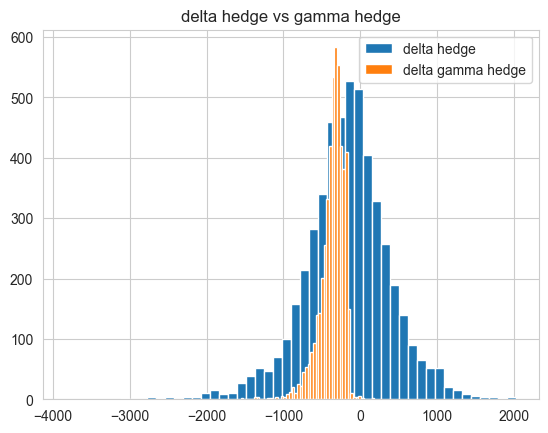

In [95]:
plt.hist(delta_hedge_base.M[:,-1],bins=50,label='delta hedge')
plt.hist(delta_gamma_hedge_base.M[:,-1],bins=50,label='delta gamma hedge')
plt.title('delta hedge vs gamma hedge')
plt.legend()
plt.show()

# Q1

In [96]:
mu_vals = np.linspace(0.05, 2, 4)
print(mu_vals)

delta_hedge_cases = []
for i in range(len(mu_vals)):
    delta_hedge_cases.append(
        ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=mu_vals[i], sigma=0.25, sigma_real=0.25,
                                                       num_of_call_option_sold=10_000, Ntrials=5000,
                                                       option_maturity=1 / 4, type_of_hedge='delta'))

delta_gamma_hedge_cases = []
for i in range(len(mu_vals)):
    delta_gamma_hedge_cases.append(
        ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=mu_vals[i], sigma=0.25, sigma_real=0.25,
                                                       num_of_call_option_sold=10_000, Ntrials=5000,
                                                       option_maturity=1 / 4, type_of_hedge='delta-gamma',
                                                       hedging_option_maturity=0.3))
# Calculate mean (expected) P&L
expected = np.zeros((len(mu_vals), 2))
for i in range(len(mu_vals)):
    for j in range(2):
        expected[i, 0] = np.mean(delta_hedge_cases[i].M[:, -1])
        expected[i, 1] = np.mean(delta_gamma_hedge_cases[i].M[:, -1])

# Calculate standard deviation
std_dev = np.zeros((len(mu_vals), 2))
for i in range(len(mu_vals)):
    for j in range(2):
        std_dev[i, 0] = np.std(delta_hedge_cases[i].M[:, -1])
        std_dev[i, 1] = np.std(delta_gamma_hedge_cases[i].M[:, -1])

# Calculate skewness
skewness = np.zeros((len(mu_vals), 2))
for i in range(len(mu_vals)):
    skewness[i, 0] = skew(delta_hedge_cases[i].M[:, -1])
    skewness[i, 1] = skew(delta_gamma_hedge_cases[i].M[:, -1])

print(np.round(skewness, 2))

[0.05 0.7  1.35 2.  ]
[[-0.34 -1.41]
 [-0.25 -2.17]
 [-0.35 -4.24]
 [-0.26 -2.18]]


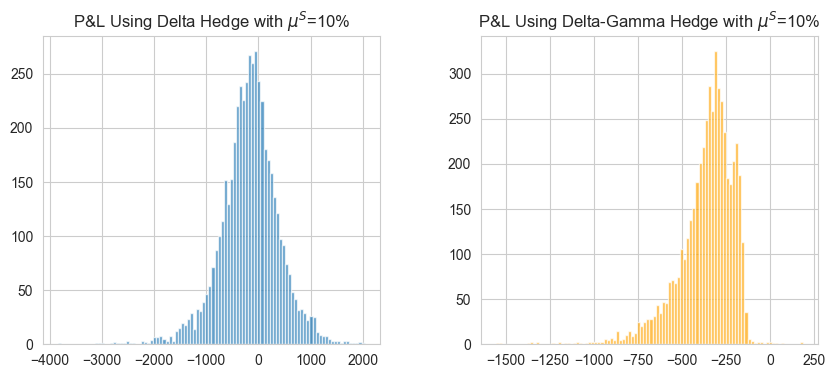

In [97]:
# Plot P&L distribution with mu=0.1
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

delta_hedge_10 = ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=0.1, sigma=0.25, sigma_real=0.25,
                                                                num_of_call_option_sold=10_000, Ntrials=5000,
                                                                option_maturity=1 / 4, type_of_hedge='delta')
delta_gamma_hedge_10 = ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=0.1, sigma=0.25,
                                                                      sigma_real=0.25, num_of_call_option_sold=10_000,
                                                                      Ntrials=5000, option_maturity=1 / 4,
                                                                      type_of_hedge='delta-gamma',
                                                                      hedging_option_maturity=0.3)

n_bins = 100
axs[0].hist(delta_hedge_10.M[:, -1], bins=n_bins, label=f'mu={0.1:.2f}', alpha=0.7)
axs[1].hist(delta_gamma_hedge_10.M[:, -1], bins=n_bins, label=f'mu={0.1:.2f}', color="orange", alpha=0.7)
axs[0].set_title(f"P&L Using Delta Hedge with $\mu^S$=10%")
axs[1].set_title(f"P&L Using Delta-Gamma Hedge with $\mu^S$=10%")
plt.show()

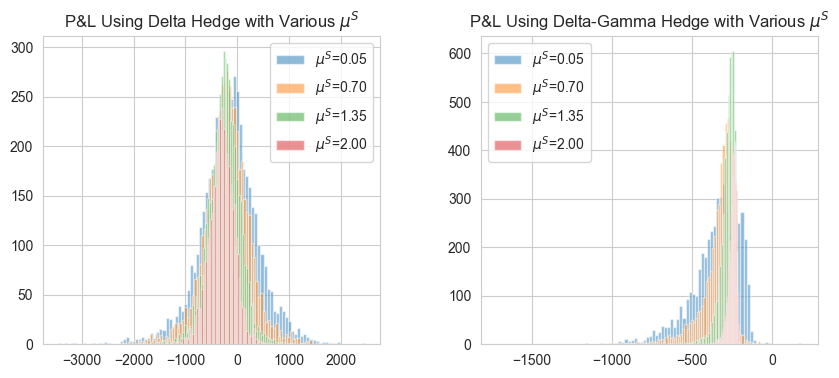

In [98]:
# Plot all P&L distribution in the same plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

n_bins = 100
for i in range(len(mu_vals)):
    axs[0].hist(delta_hedge_cases[i].M[:, -1], bins=n_bins, label=f'$\mu^S$={mu_vals[i]:.2f}', alpha=0.5)
    axs[1].hist(delta_gamma_hedge_cases[i].M[:, -1], bins=n_bins, label=f'$\mu^S$={mu_vals[i]:.2f}', alpha=0.5)
    axs[0].set_title(f"P&L Using Delta Hedge with Various $\mu^S$")
    axs[1].set_title(f"P&L Using Delta-Gamma Hedge with Various $\mu^S$")
    axs[0].legend()
    axs[1].legend()
plt.show()

In [99]:
mu_vals = np.linspace(0, 0.6, 4)
print(mu_vals)

delta_hedge_cases = []
for i in range(len(mu_vals)):
    delta_hedge_cases.append(
        ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=mu_vals[i], sigma=0.25, sigma_real=0.25,
                                                       num_of_call_option_sold=10_000, Ntrials=5000,
                                                       option_maturity=1 / 4, type_of_hedge='delta'))

delta_gamma_hedge_cases = []
for i in range(len(mu_vals)):
    delta_gamma_hedge_cases.append(
        ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=mu_vals[i], sigma=0.25, sigma_real=0.25,
                                                       num_of_call_option_sold=10_000, Ntrials=5000,
                                                       option_maturity=1 / 4, type_of_hedge='delta-gamma',
                                                       hedging_option_maturity=0.3))
# Calculate mean (expected) P&L
expected = np.zeros((len(mu_vals), 2))
for i in range(len(mu_vals)):
    for j in range(2):
        expected[i, 0] = np.mean(delta_hedge_cases[i].M[:, -1])
        expected[i, 1] = np.mean(delta_gamma_hedge_cases[i].M[:, -1])

# Calculate standard deviation
std_dev = np.zeros((len(mu_vals), 2))
for i in range(len(mu_vals)):
    for j in range(2):
        std_dev[i, 0] = np.std(delta_hedge_cases[i].M[:, -1])
        std_dev[i, 1] = np.std(delta_gamma_hedge_cases[i].M[:, -1])

# Calculate skewness
skewness = np.zeros((len(mu_vals), 2))
for i in range(len(mu_vals)):
    skewness[i, 0] = skew(delta_hedge_cases[i].M[:, -1])
    skewness[i, 1] = skew(delta_gamma_hedge_cases[i].M[:, -1])

print(np.round(skewness, 2))

[0.  0.2 0.4 0.6]
[[-0.28 -1.36]
 [-0.42 -1.54]
 [-0.41 -1.66]
 [-0.34 -1.88]]


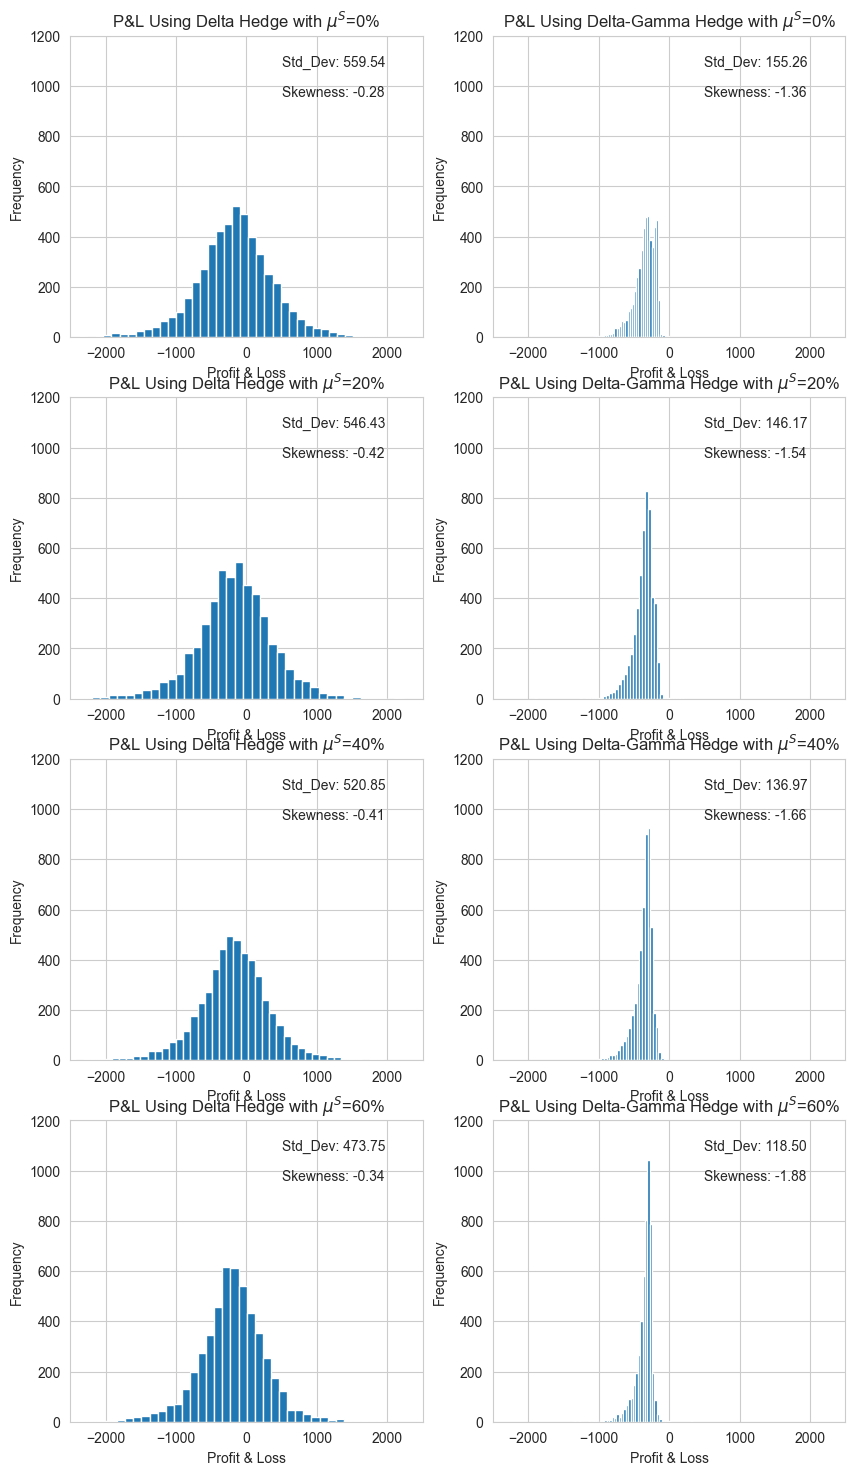

In [100]:
# Plot P&L for individual delta and delta-gamma hedge cases as mu varies
fig, axs = plt.subplots(len(mu_vals), 2, figsize=(10, len(mu_vals) * 4.5))
# plt.subplots_adjust(wspace=0.3, hspace=0.3)

n_bins = 50
# Loop through all subplots to set axis limits
for i in range(len(mu_vals)):
    # First column plots delta hedge cases
    axs[i, 0].hist(delta_hedge_cases[i].M[:, -1], bins=n_bins)
    axs[i, 0].set_xlim(-2500, 2500)
    axs[i, 0].set_ylim(0, 60000 / n_bins)
    # Second column plots delta-gamma hedge cases
    axs[i, 1].hist(delta_gamma_hedge_cases[i].M[:, -1], bins=n_bins)
    axs[i, 1].set_xlim(-2500, 2500)
    axs[i, 1].set_ylim(0, 60000 / n_bins)

# Loop through all subplots to annotate with skewness and std
for i in range(len(mu_vals)):
    for j in range(2):
        axs[i, j].annotate(f'Std_Dev: {std_dev[i, j]:.2f}', xy=(0.6, 0.9), xycoords='axes fraction')
        axs[i, j].annotate(f'Skewness: {skewness[i, j]:.2f}', xy=(0.6, 0.8), xycoords='axes fraction')
        axs[i, j].set_xlabel('Profit & Loss')
        axs[i, j].set_ylabel('Frequency')

for i in range(len(mu_vals)):
    axs[i, 0].set_title(f"P&L Using Delta Hedge with $\mu^S$={mu_vals[i] * 100:.0f}%")
    axs[i, 1].set_title(f"P&L Using Delta-Gamma Hedge with $\mu^S$={mu_vals[i] * 100:.0f}%")
plt.show()

In [101]:
mu_vals = np.linspace(0, 2, 41)
print(mu_vals)

delta_hedge_cases = []
for i in range(len(mu_vals)):
    delta_hedge_cases.append(
        ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=mu_vals[i], sigma=0.25, sigma_real=0.25,
                                                       num_of_call_option_sold=10_000, Ntrials=5000,
                                                       option_maturity=1 / 4, type_of_hedge='delta'))

delta_gamma_hedge_cases = []
for i in range(len(mu_vals)):
    delta_gamma_hedge_cases.append(
        ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10, mu=mu_vals[i], sigma=0.25, sigma_real=0.25,
                                                       num_of_call_option_sold=10_000, Ntrials=5000,
                                                       option_maturity=1 / 4, type_of_hedge='delta-gamma',
                                                       hedging_option_maturity=0.3))
# Calculate mean (expected) P&L
expected = np.zeros((len(mu_vals), 2))
for i in range(len(mu_vals)):
    for j in range(2):
        expected[i, 0] = np.mean(delta_hedge_cases[i].M[:, -1])
        expected[i, 1] = np.mean(delta_gamma_hedge_cases[i].M[:, -1])

# Calculate standard deviation
std_dev = np.zeros((len(mu_vals), 2))
for i in range(len(mu_vals)):
    for j in range(2):
        std_dev[i, 0] = np.std(delta_hedge_cases[i].M[:, -1])
        std_dev[i, 1] = np.std(delta_gamma_hedge_cases[i].M[:, -1])

# Calculate skewness
skewness = np.zeros((len(mu_vals), 2))
for i in range(len(mu_vals)):
    skewness[i, 0] = skew(delta_hedge_cases[i].M[:, -1])
    skewness[i, 1] = skew(delta_gamma_hedge_cases[i].M[:, -1])

print(np.round(skewness, 2))

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]
[[-0.28 -1.36]
 [-0.34 -1.41]
 [-0.39 -1.51]
 [-0.36 -1.44]
 [-0.42 -1.54]
 [-0.5  -1.49]
 [-0.49 -1.64]
 [-0.42 -1.6 ]
 [-0.41 -1.66]
 [-0.36 -1.52]
 [-0.33 -1.79]
 [-0.35 -2.07]
 [-0.34 -1.88]
 [-0.25 -2.2 ]
 [-0.25 -2.17]
 [-0.33 -2.43]
 [-0.48 -2.6 ]
 [-0.53 -2.26]
 [-0.53 -3.3 ]
 [-0.52 -4.21]
 [-0.59 -2.93]
 [-0.55 -2.65]
 [-0.5  -1.98]
 [-0.44 -2.32]
 [-0.4  -2.72]
 [-0.39 -3.63]
 [-0.36 -4.29]
 [-0.35 -4.24]
 [-0.31 -3.37]
 [-0.27 -2.35]
 [-0.27 -1.8 ]
 [-0.25 -2.24]
 [-0.24 -3.1 ]
 [-0.22 -4.04]
 [-0.22 -4.14]
 [-0.22 -2.08]
 [-0.24 -2.47]
 [-0.25 -2.48]
 [-0.25 -2.15]
 [-0.25 -2.21]
 [-0.26 -2.18]]


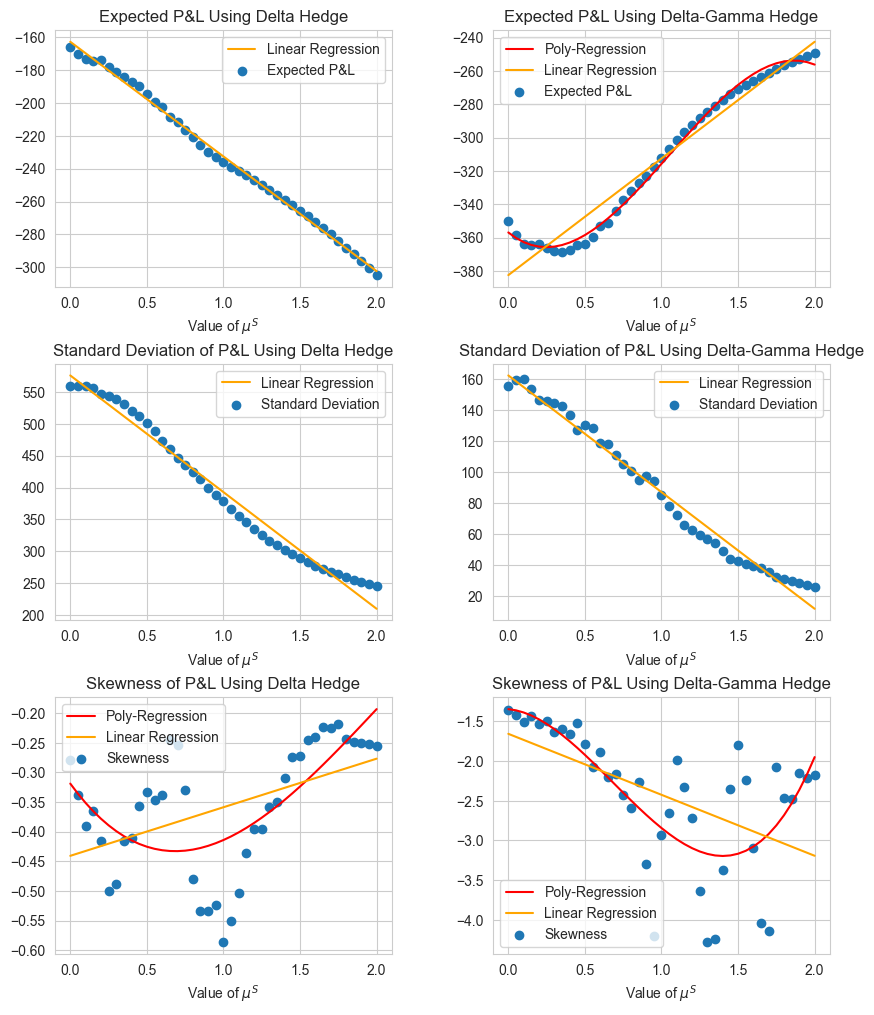

In [102]:
# Plot linear regression of mean, std and skewness for both cases
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X = mu_vals
degree = 3
## Plot polynomial regressions
Y_data = expected[:, 1]
# Perform polynomial regression
coefficients2 = np.polyfit(X, Y_data, deg=degree)
polynomial2 = np.poly1d(coefficients2)
Y_poly_line = polynomial2(X)
# Plotting
axs[0, 1].plot(X, Y_poly_line, color='red', label='Poly-Regression')

Y_data = skewness[:, 0]
# Perform polynomial regression
coefficients2 = np.polyfit(X, Y_data, deg=degree)
polynomial2 = np.poly1d(coefficients2)
Y_poly_line = polynomial2(X)
# Plotting
axs[2, 0].plot(X, Y_poly_line, color='red', label='Poly-Regression')

Y_data = skewness[:, 1]
# Perform polynomial regression
coefficients2 = np.polyfit(X, Y_data, deg=degree)
polynomial2 = np.poly1d(coefficients2)
Y_poly_line = polynomial2(X)
# Plotting
axs[2, 1].plot(X, Y_poly_line, color='red', label='Poly-Regression')

## Plot linear regression
for i in range(3):
    for j in range(2):
        if i == 0:
            Y_data = expected[:, j]
        if i == 1:
            Y_data = std_dev[:, j]
        if i == 2:
            Y_data = skewness[:, j]
        # Perform linear regression
        coefficients = np.polyfit(X, Y_data, 1)
        polynomial = np.poly1d(coefficients)
        Y_line = polynomial(X)
        # Plotting
        axs[i, j].plot(X, Y_line, color='orange', label='Linear Regression')
        if i == 0:
            axs[i, j].scatter(X, Y_data, label='Expected P&L')
        if i == 1:
            axs[i, j].scatter(X, Y_data, label='Standard Deviation')
        if i == 2:
            axs[i, j].scatter(X, Y_data, label='Skewness')
        axs[i, j].legend()
        axs[i, j].set_xlabel('Value of $\mu^S$')

axs[0, 0].set_title('Expected P&L Using Delta Hedge')
axs[0, 1].set_title('Expected P&L Using Delta-Gamma Hedge')
axs[1, 0].set_title('Standard Deviation of P&L Using Delta Hedge')
axs[1, 1].set_title('Standard Deviation of P&L Using Delta-Gamma Hedge')
axs[2, 0].set_title('Skewness of P&L Using Delta Hedge')
axs[2, 1].set_title('Skewness of P&L Using Delta-Gamma Hedge')
plt.show()

In [103]:
del delta_hedge_cases
del delta_gamma_hedge_cases

In [104]:
end_pnl_delta=[]
end_pnl_delta_gamma=[]
for i in np.linspace(0.05,2.0,4):
    obj=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=i,sigma=0.25,sigma_real=0.25,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta')
    obj2=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=i,sigma=0.25,sigma_real=0.25,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta-gamma',hedging_option_maturity=0.3)
    end_pnl_delta.append(obj.M[:,-1])
    end_pnl_delta_gamma.append(obj2.M[:,-1])

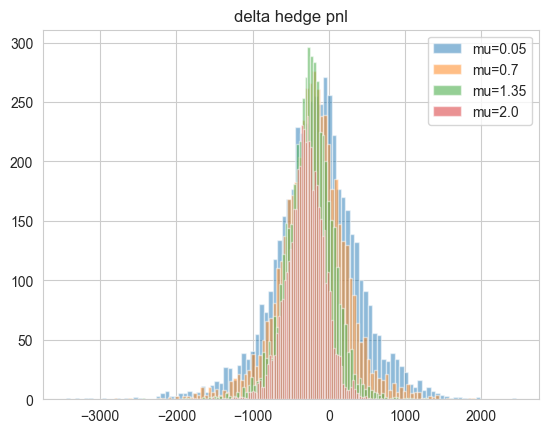

In [105]:
for idx,data in enumerate(end_pnl_delta):
    plt.hist(data,bins=100,label='mu={}'.format(np.round(np.linspace(0.05,2.0,4)[idx],2)),alpha=0.5)
plt.title('delta hedge pnl')
plt.legend()
plt.show()

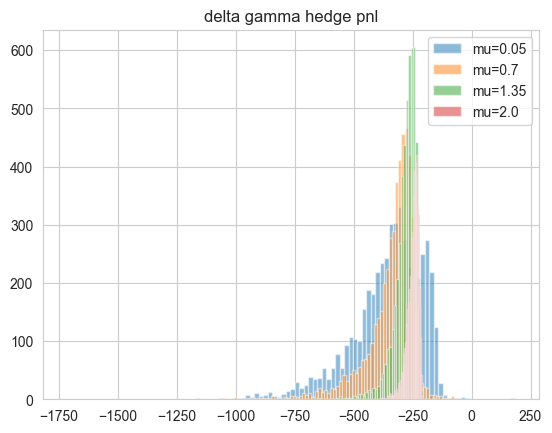

In [106]:
for idx,data in enumerate(end_pnl_delta_gamma):
    plt.hist(data,bins=100,label='mu={}'.format(np.round(np.linspace(0.05,2.0,4)[idx],2)),alpha=0.5)
plt.title('delta gamma hedge pnl')
plt.legend()
plt.show()

# Q2    

In [107]:
# plot subplots of delta hedge and delta gamma hedge for their stock path, alpha position, m position

In [108]:
def plot_delta_hedge(delta_hedge_base:ATM_Call_Option_Dynamic_Hedging_Following_prof,trial:int):
    # fig,ax=plt.subplots(4,1,figsize=(10,20))
    fig,ax=plt.subplots(4,1,figsize=(10,20),gridspec_kw={'width_ratios': [2]})
    ax[0].plot(delta_hedge_base.t,delta_hedge_base.S[trial,:],label='S_t')
    ax[0].set_title('Stock Price',fontsize=16)
    ax[0].set_ylim([9,12])
    ax[0].legend(fontsize=14)
    ax[0].tick_params(axis='both', which='major', labelsize=12)

    ax[1].plot(delta_hedge_base.t,delta_hedge_base.sold_option_delta[trial,:],label='g delta_t')
    ax[1].set_title('Sold Option Delta',fontsize=16)
    ax[1].set_ylim([0,1])
    ax[1].legend(fontsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=12)

    ax[2].plot(delta_hedge_base.t,delta_hedge_base.alpha[trial,:],label='alpha_t')
    ax[2].set_title('Stock Position (alpha)',fontsize=16)
    ax[2].set_ylim([0,11000])
    ax[2].legend(fontsize=14)
    ax[2].tick_params(axis='both', which='major', labelsize=12)

    ax[3].plot(delta_hedge_base.t,delta_hedge_base.M[trial,:],label='M_t')
    ax[3].set_title('Cash Position (M)',fontsize=16)
    ax[3].set_ylim([-110000,0])
    ax[3].legend(fontsize=14)
    ax[3].tick_params(axis='both', which='major', labelsize=12)
    # ax[3].hist(delta_hedge_base.M[:,-1],bins=100,label='delta hedge pnl')
    # ax[3].set_title('delta hedge pnl')
    # ax[3].legend()
    plt.show()

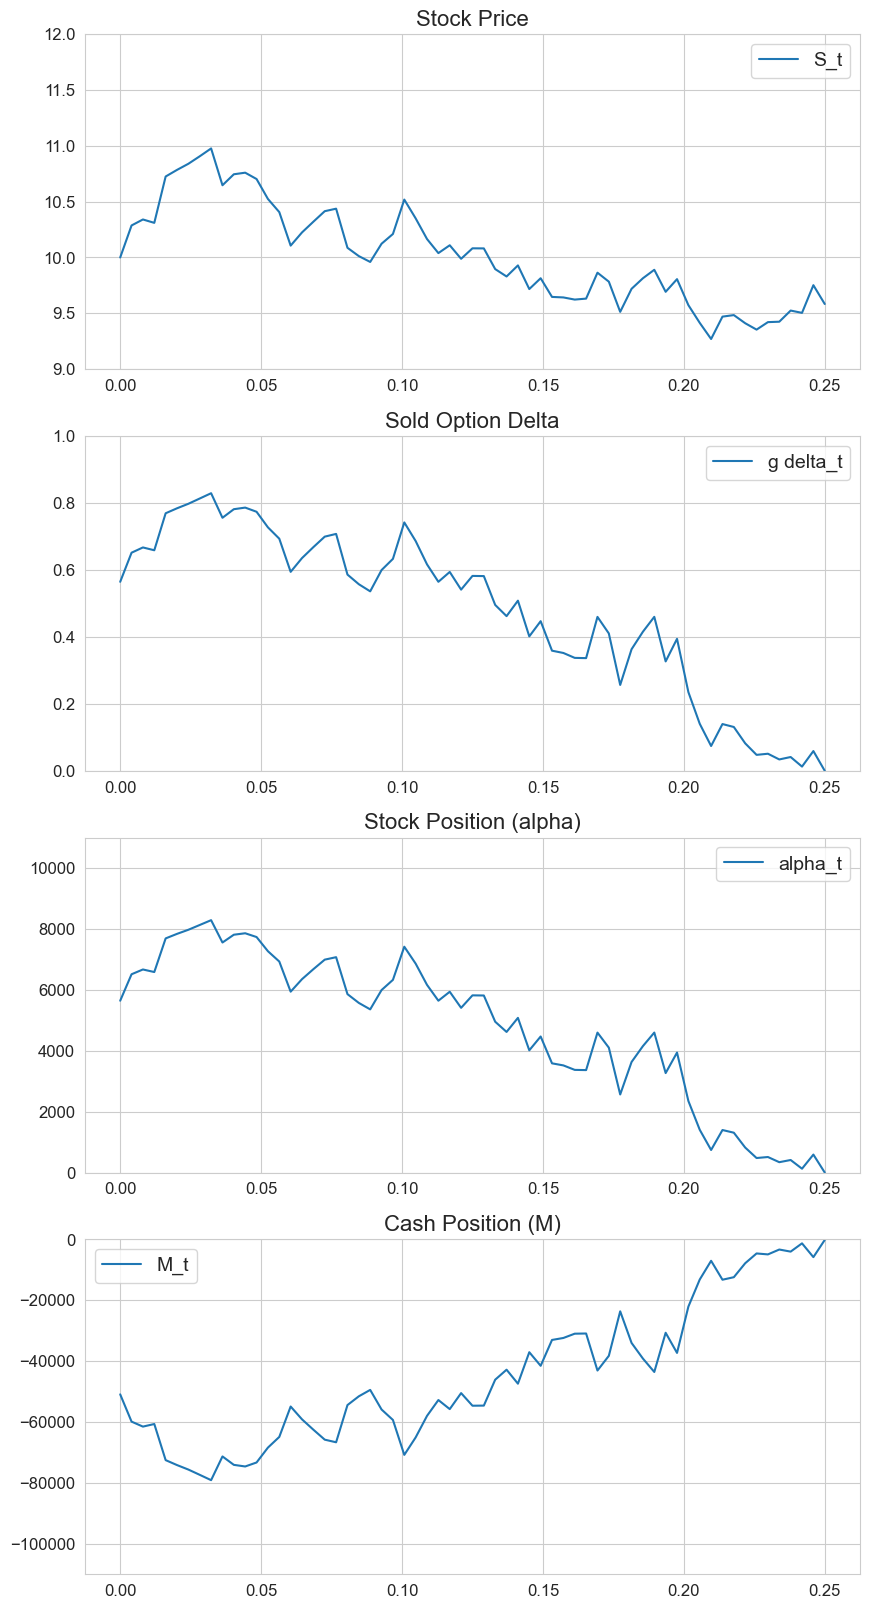

In [109]:
plot_delta_hedge(delta_hedge_base,trial=0)

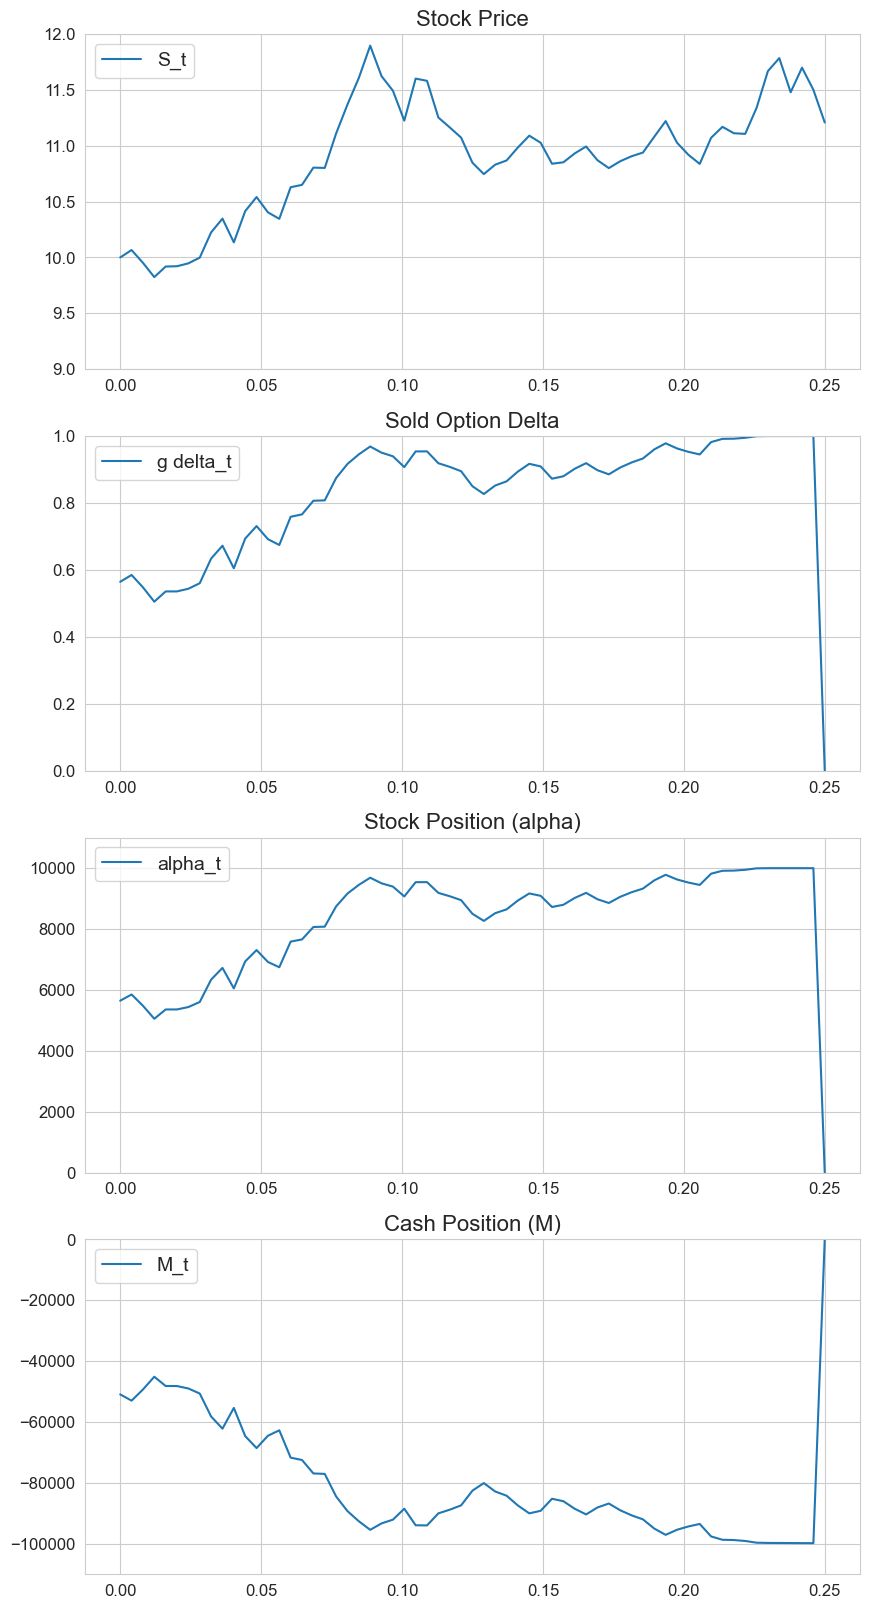

In [110]:
plot_delta_hedge(delta_hedge_base,trial=1)

In [111]:
def plot_delta_gamma_hedge(delta_gamma_hedge_base:ATM_Call_Option_Dynamic_Hedging_Following_prof,trial:int):
    # fig,ax=plt.subplots(5,1,figsize=(10,20))
    fig,ax=plt.subplots(5,1,figsize=(10,25),gridspec_kw={'width_ratios': [2]})
    ax[0].plot(delta_gamma_hedge_base.t,delta_gamma_hedge_base.S[trial,:],label='S_t')
    ax[0].set_title('Stock Price',fontsize=16)
    ax[0].set_ylim([9,12])
    ax[0].legend(fontsize=14)
    ax[0].tick_params(axis='both', which='major', labelsize=12)

    ax[1].plot(delta_gamma_hedge_base.t,delta_gamma_hedge_base.sold_option_delta[trial,:],label='g delta_t')
    ax[1].plot(delta_hedge_base.t,delta_gamma_hedge_base.sold_option_gamma[trial,:],label='g gamma_t')
    ax[1].plot(delta_hedge_base.t,delta_gamma_hedge_base.hedge_option_delta[trial,:],label='h delta_t')
    ax[1].plot(delta_hedge_base.t,delta_gamma_hedge_base.hedge_option_gamma[trial,:],label='h gamma_t')
    ax[1].set_title('Sold Option Delta&Gamma and Hedge Option Delta&Gamma',fontsize=16)
    ax[1].set_ylim([0,1])
    ax[1].legend(fontsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=12)

    ax[2].plot(delta_gamma_hedge_base.t,delta_gamma_hedge_base.alpha[trial,:],label='alpha_t')
    ax[2].set_title('Stock Position (alpha)',fontsize=16)
    ax[2].legend(fontsize=14)
    ax[2].tick_params(axis='both', which='major', labelsize=12)

    ax[3].plot(delta_gamma_hedge_base.t,delta_gamma_hedge_base.M[trial,:],label='M_t')
    ax[3].set_title('Cash Position (M)',fontsize=16)
    ax[3].legend(fontsize=14)
    ax[3].tick_params(axis='both', which='major', labelsize=12)

    ax[4].plot(delta_gamma_hedge_base.t,delta_gamma_hedge_base.gamma[trial,:],label='gamma_t')
    ax[4].set_title('Hedge Option Position (gamma)',fontsize=16)
    ax[4].legend(fontsize=14)
    ax[4].tick_params(axis='both', which='major', labelsize=12)
    # ax[4].hist(delta_gamma_hedge_base.M[:,-1],bins=100,label='delta gamma hedge pnl')
    # ax[4].set_title('delta gamma hedge pnl')
    # ax[4].legend()
    plt.show()

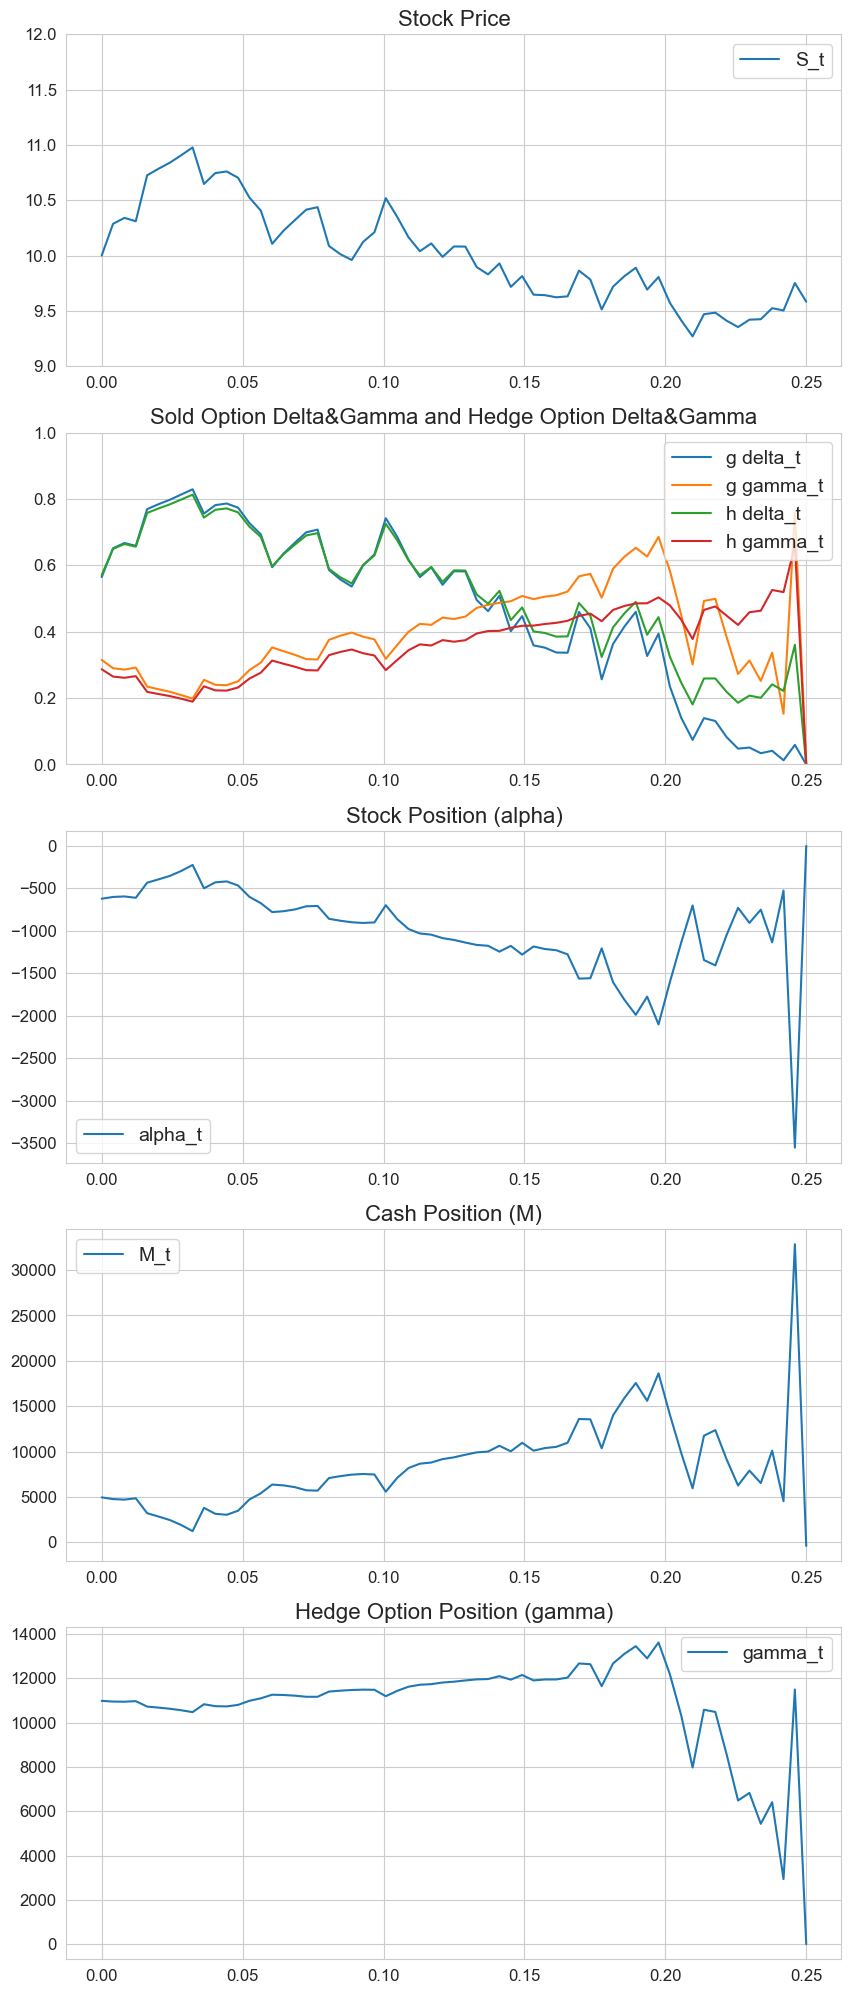

In [112]:
plot_delta_gamma_hedge(delta_gamma_hedge_base,trial=0)

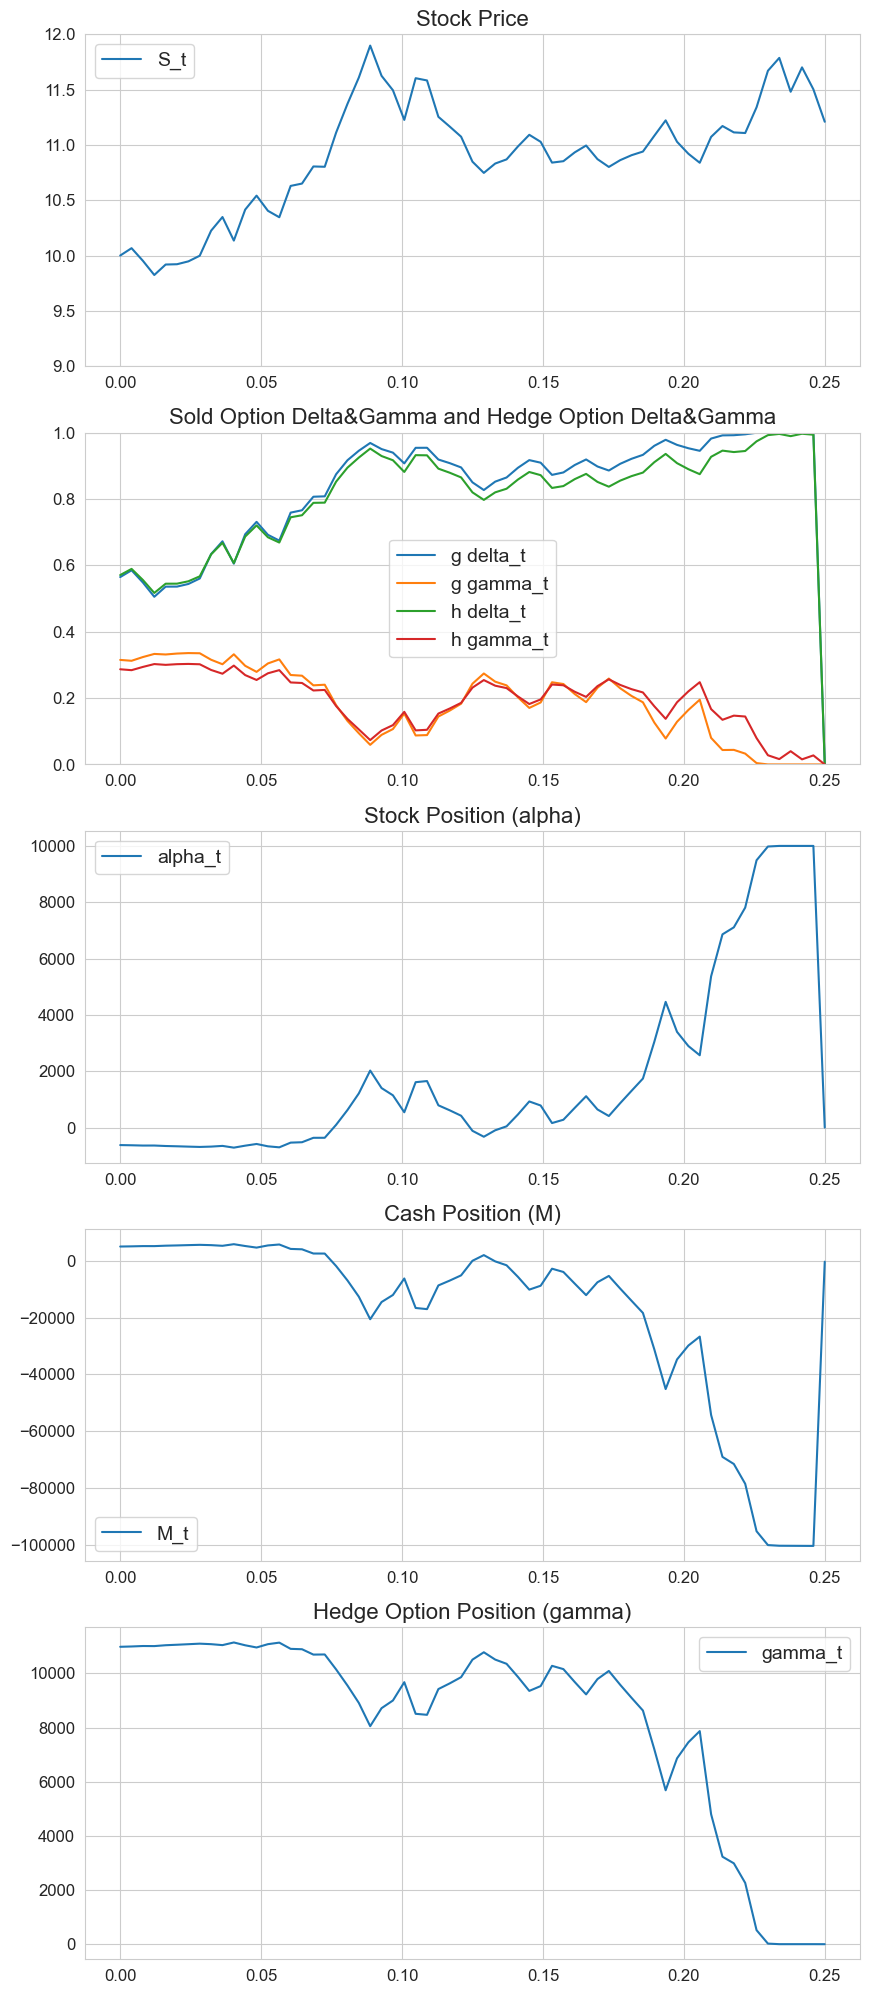

In [113]:
plot_delta_gamma_hedge(delta_gamma_hedge_base,trial=1)

# Q3

In [ ]:
obj_delta_vol=[]
correct_obj_delta_vol=[]
obj_delta_gamma_vol=[]
correct_obj_delta_gamma_vol=[]
for i in np.linspace(0.2, 0.3,5):
    obj=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=0.25,sigma_real=i,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta')
    obj2=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=0.25,sigma_real=i,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta-gamma',hedging_option_maturity=0.3)
    correct_obj=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=i,sigma_real=i,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta')
    correct_obj2=ATM_Call_Option_Dynamic_Hedging_Following_prof(spot_price=10,mu=0.1,sigma=i,sigma_real=i,num_of_call_option_sold=10_000,Ntrials=5000,option_maturity=1/4,type_of_hedge='delta-gamma',hedging_option_maturity=0.3)
    obj_delta_vol.append(obj)
    obj_delta_gamma_vol.append(obj2)
    correct_obj_delta_vol.append(correct_obj)
    correct_obj_delta_gamma_vol.append(correct_obj2)

In [ ]:
for idx,obj in enumerate(obj_delta_vol):
    plt.hist(obj.M[:,-1],bins=100,label='vol={}'.format(np.round(np.linspace(0.2, 0.3,5)[idx],2)),alpha=0.5)
plt.title('delta hedge pnl')
plt.legend()
plt.show()

In [ ]:
# plot position of delta hedge
fig,ax=plt.subplots(5,1,figsize=(10,30))
for idx,(obj,correct_obj) in enumerate(zip(obj_delta_vol,correct_obj_delta_vol)):
    ax[idx].plot(obj.t,obj.alpha[0,:],label=f'alpha position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='red')
    ax[idx].plot(obj.t,correct_obj.alpha[0,:],label=f'correct alpha position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='blue')
    ax[idx].plot(obj.t,obj.alpha[0,:]-correct_obj.alpha[0,:],label=f'alpha error when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='green')
    # plt.plot(obj.t,obj.gamma[0,:],label=f'gamma position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='red',linestyle='--')
    # plt.plot(obj.t,correct_obj.gamma[0,:],label=f'correct gamma position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='blue',linestyle='--')
    # plt.plot(obj.t,obj.gamma[0,:]-correct_obj.gamma[0,:],label=f'gamma error when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='green',linestyle='--')
    ax[idx].set_title(f'Delta hedge position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}')
    ax[idx].legend()
plt.show()

In [ ]:
for idx,obj in enumerate(obj_delta_gamma_vol[::-1]):
    plt.hist(obj.M[:,-1],bins=100,label='vol={}'.format(np.round(np.linspace(0.2, 0.3,5)[::-1][idx],2)),alpha=0.5, edgecolor= "white")
plt.title('delta gamma hedge pnl')
plt.legend()
plt.show()

In [ ]:
fig,ax=plt.subplots(5,1,figsize=(10,30))
# plot position of delta gamma hedge
for idx,(obj,correct_obj) in enumerate(zip(obj_delta_gamma_vol,correct_obj_delta_gamma_vol)):
    ax[idx].plot(obj.t,obj.alpha[0,:],label=f'alpha position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='red')
    ax[idx].plot(obj.t,correct_obj.alpha[0,:],label=f'correct alpha position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='blue')
    ax[idx].plot(obj.t,obj.alpha[0,:]-correct_obj.alpha[0,:],label=f'alpha error when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='green')
    ax[idx].plot(obj.t,obj.gamma[0,:],label=f'gamma position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='red',linestyle='--')
    ax[idx].plot(obj.t,correct_obj.gamma[0,:],label=f'correct gamma position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='blue',linestyle='--')
    ax[idx].plot(obj.t,obj.gamma[0,:]-correct_obj.gamma[0,:],label=f'gamma error when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}',color='green',linestyle='--')
    ax[idx].set_title(f'Delta gamma hedge position when real_vol={np.round(np.linspace(0.2, 0.3,5)[idx],2)}')
    ax[idx].legend()
plt.show()